### The official code for MOESTKF 

## Hi, there. Here is the official code following this link: 
https://drive.google.com/file/d/1ewDuJcIieAu1RMBeyabzz6etI4zLVang/view?usp=sharing=

To solve gap 1 about learning potential distribution of spatial correlations, we design a MOE-based subgraph structure for spatial interpolation task. There are four steps inside of it. 
 #### 1) Feature-wise subgraph generation.  2) Distribution generation of spatial correlations for different feature.  3) Information aggregation by Attention and GNNs.  4) MOE for fusing the distribution of spatial correlations under different features. 5）STKF for training. Let's do it one by one.


   


Let's do it on step 1. Before that, let's import necessary libraries and create the toy dataset.

In [1]:
import os
import numpy as np
import six.moves.cPickle as pickle
import torch
import torch.nn as nn
import torch.utils.data as data
import os
import pandas as pd
import torch


Step 1). Feature-wise subgraph generation.

In [2]:
from MOESTKF_functions import Toy_generation, get_complete_stations, Feature_wise_Subgraph

##############################
#1. Input: Toy example generation #Can be replaced by other datasets here.
##############################
# Example usage
N, T, F, Prop = 100, 365*24, 8, 'Gaussian'
station_info, station_value = Toy_generation(N, T, F, Prop)
complete_stations, complete_indices = get_complete_stations(station_info, station_value)
K = 5
subgraph_matrix = Feature_wise_Subgraph(station_info, station_value, complete_stations, complete_indices, K)#Subgraph Matrix: (16, 8)

print("Feature-wise Subgraph Matrix:")
print(subgraph_matrix.shape)#Feature-wise Subgraph Matrix: (16, 8)

# Initialize the new matrix with the desired shape
complete_sub_matrix = np.empty((subgraph_matrix.shape[0], subgraph_matrix.shape[1], 6), dtype=object)

# Fill the new matrix
for i, complete_station in enumerate(complete_stations):
    for j in range(subgraph_matrix.shape[1]):
        complete_sub_matrix[i, j] = np.insert(subgraph_matrix[i, j], 0, complete_station)

# Example output for verification
print("Complete_Sub_matrix.shape",complete_sub_matrix.shape)


Feature-wise Subgraph Matrix:
(16, 8)
Complete_Sub_matrix.shape (16, 8, 6)


In [51]:
type(station_value)

torch.Tensor

In [52]:
station_info

array([['Station_0', 18.80045509338379, 157.50192260742188],
       ['Station_1', 18.343154907226562, 156.8158416748047],
       ['Station_2', 18.8382511138916, 157.37026977539062],
       ['Station_3', 19.230314254760742, 157.4779815673828],
       ['Station_4', 18.644081115722656, 157.56739807128906],
       ['Station_5', 18.8884220123291, 158.13040161132812],
       ['Station_6', 18.73626708984375, 157.53309631347656],
       ['Station_7', 18.91944122314453, 157.33349609375],
       ['Station_8', 18.79873275756836, 157.5618438720703],
       ['Station_9', 18.491159439086914, 157.5819091796875],
       ['Station_10', 18.524808883666992, 157.14450073242188],
       ['Station_11', 18.792953491210938, 157.57681274414062],
       ['Station_12', 18.481542587280273, 157.3944091796875],
       ['Station_13', 19.595975875854492, 157.48443603515625],
       ['Station_14', 18.98775863647461, 158.33477783203125],
       ['Station_15', 18.977527618408203, 156.93807983398438],
       ['Station_16

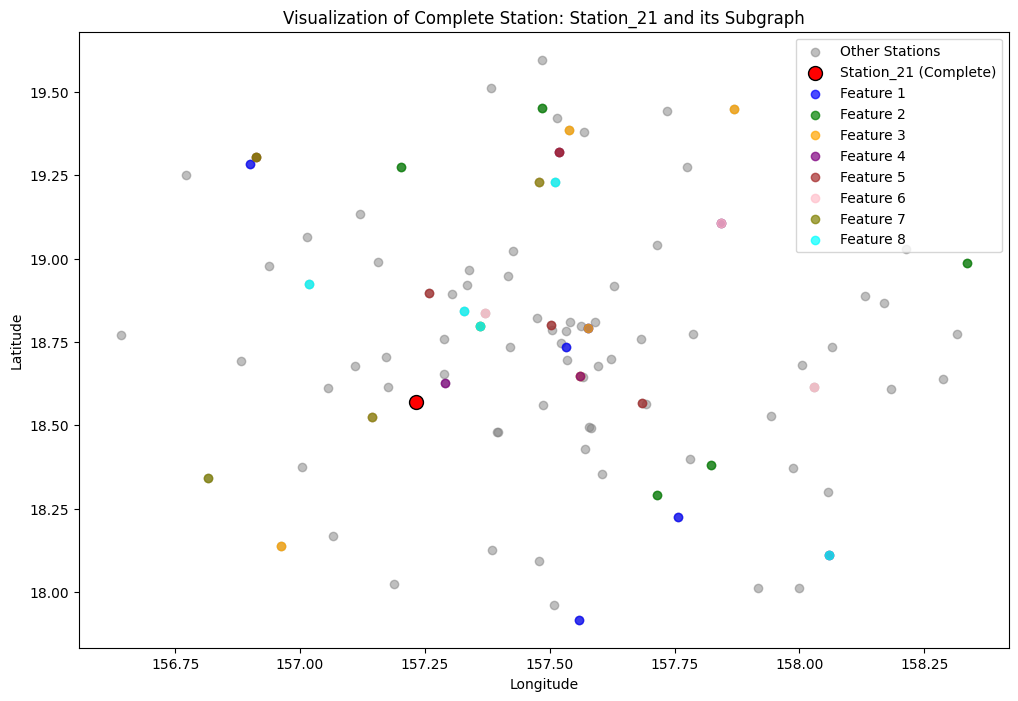

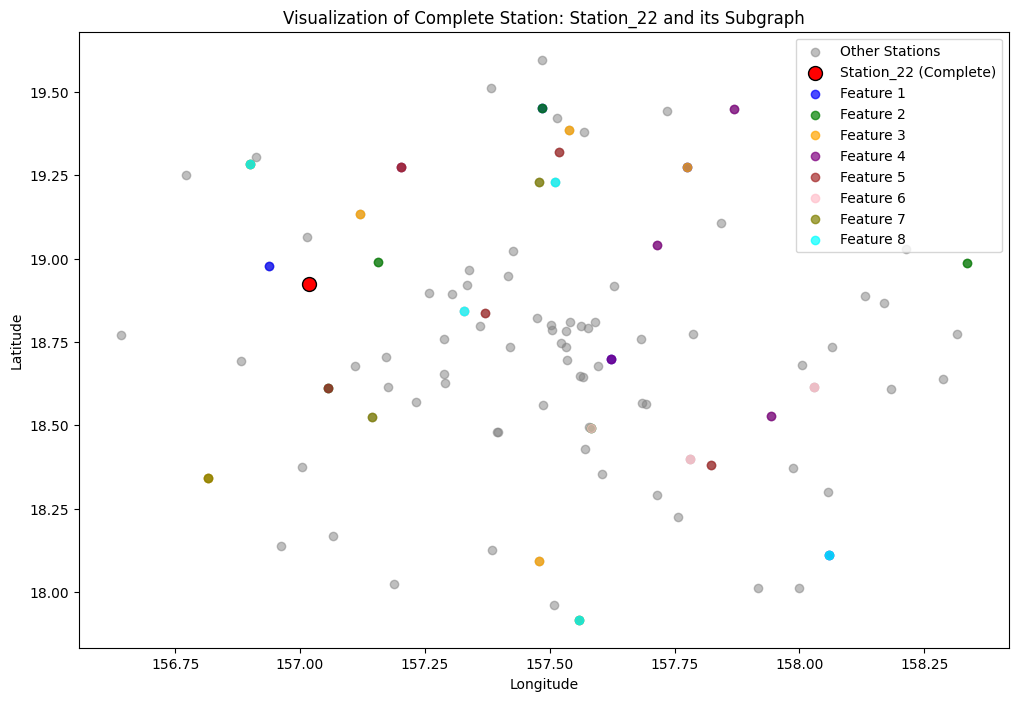

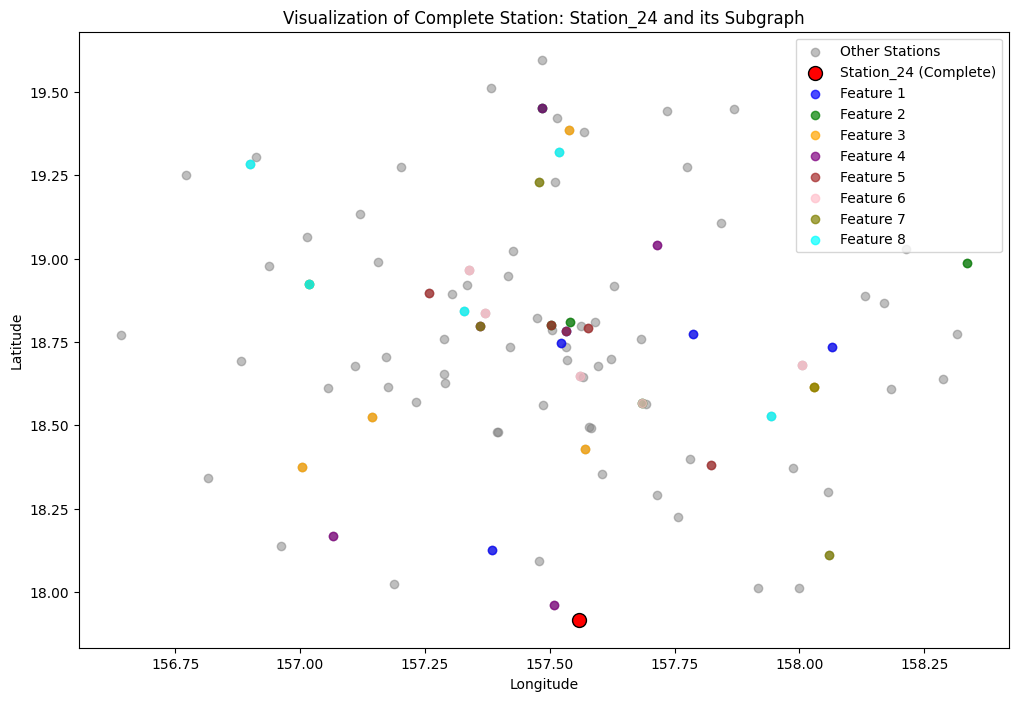

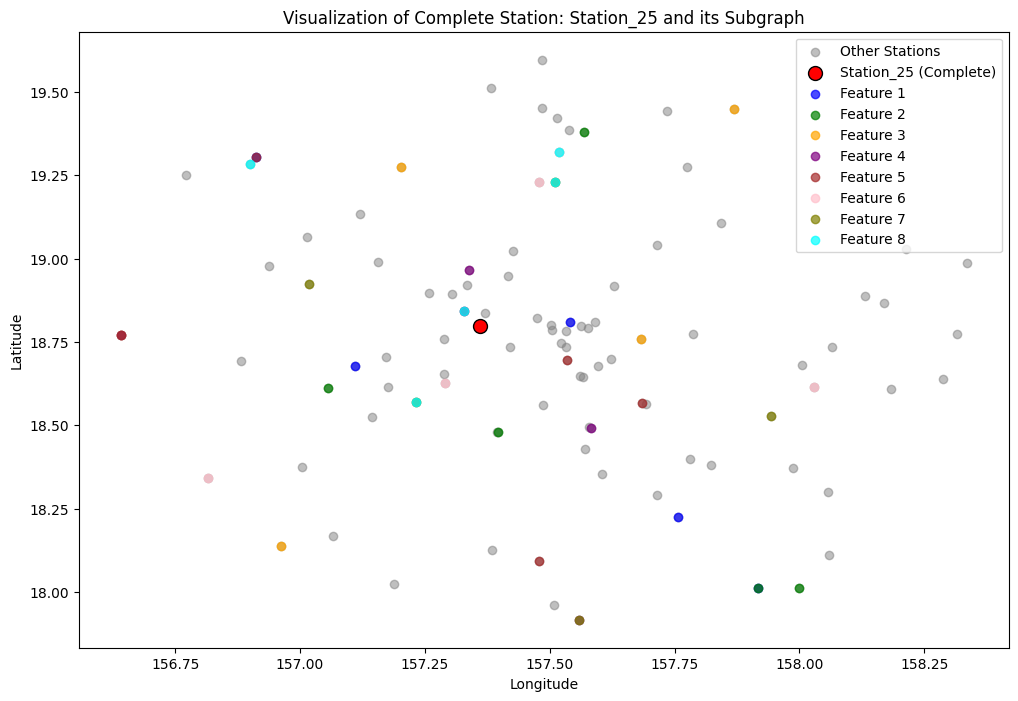

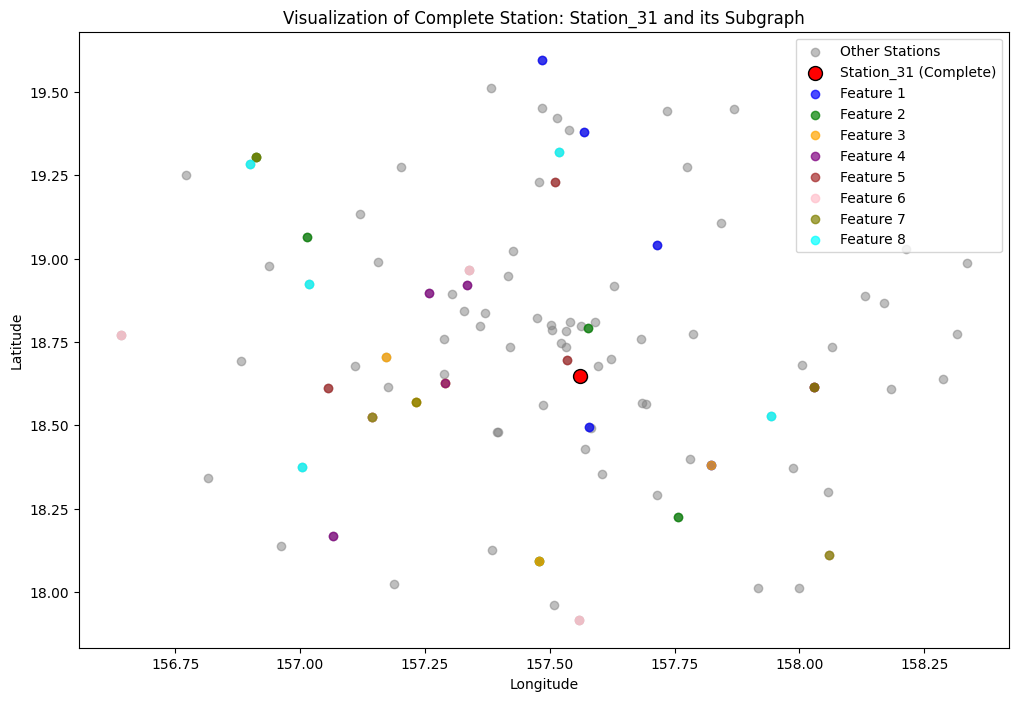

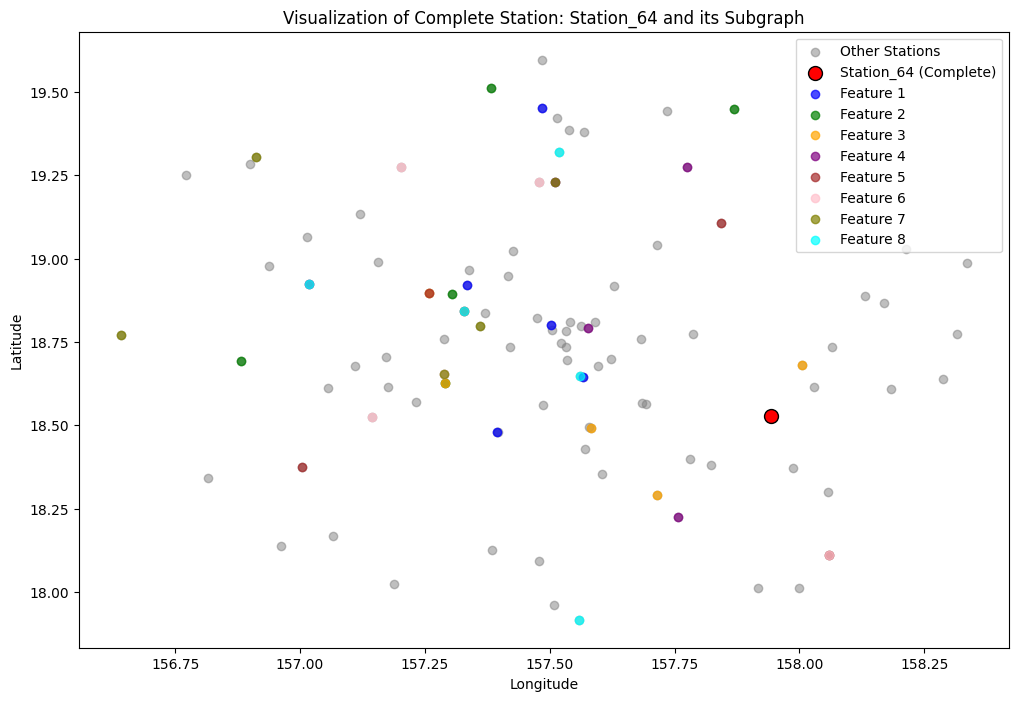

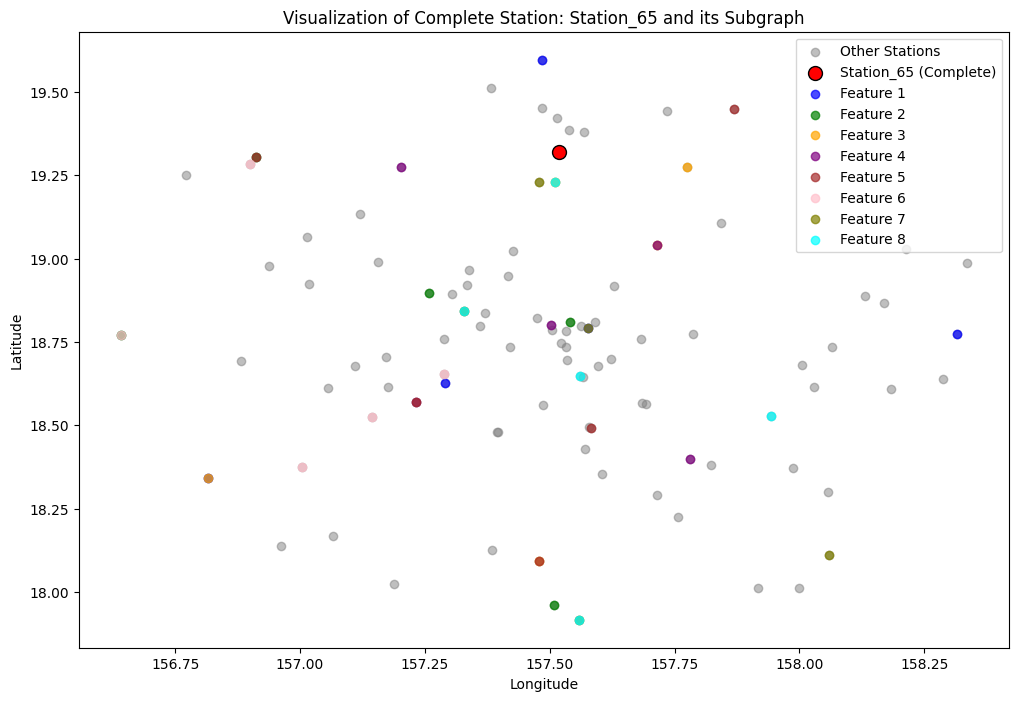

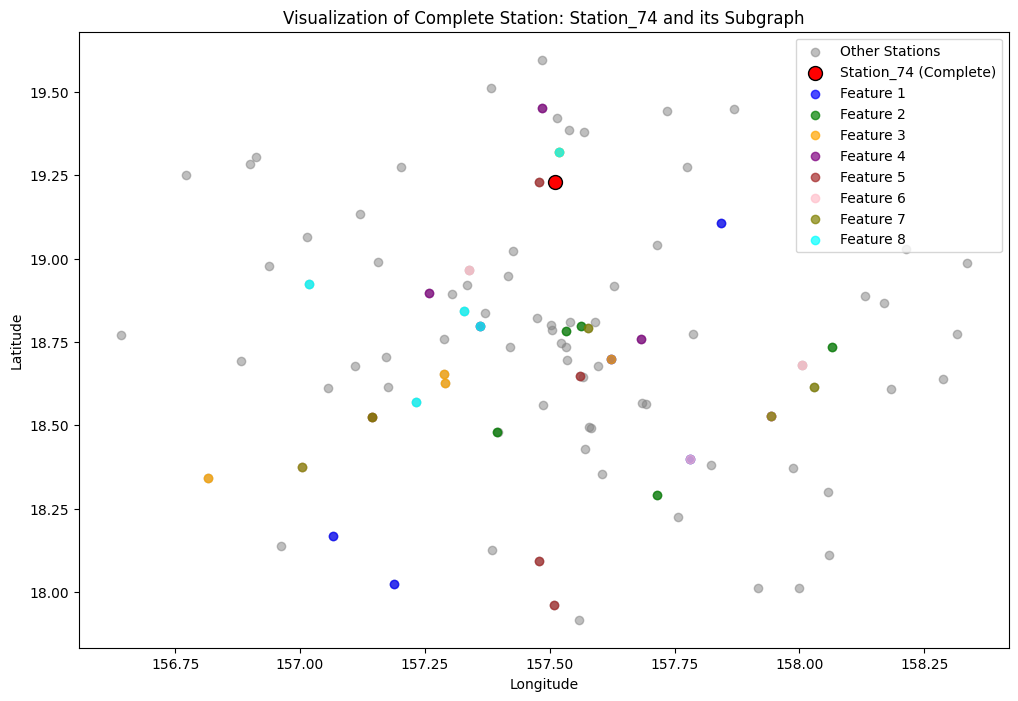

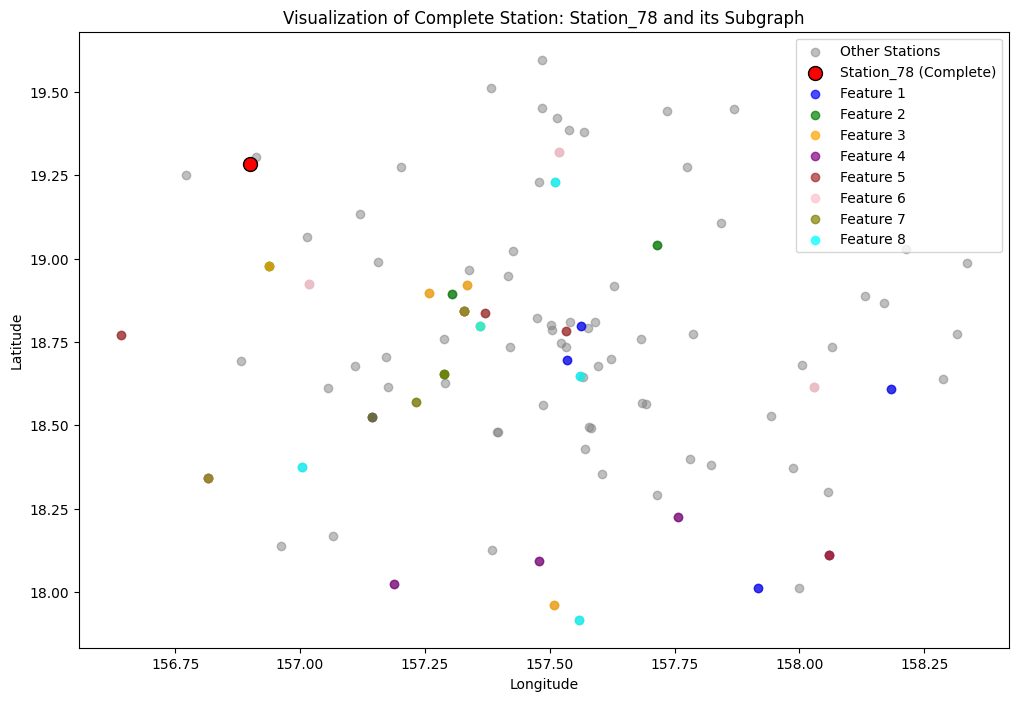

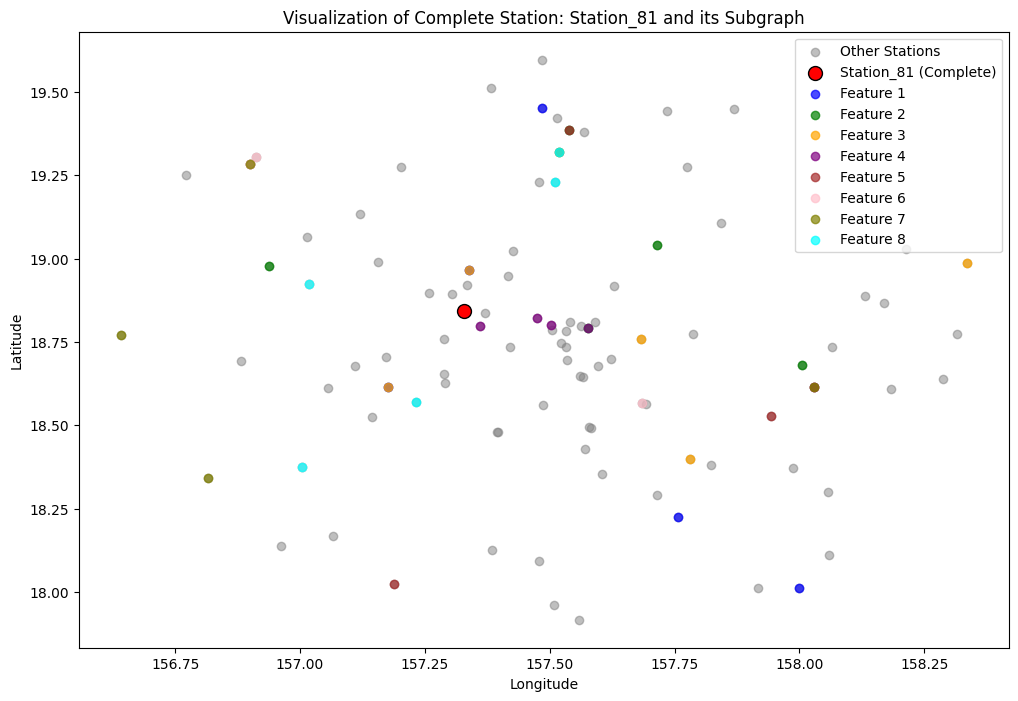

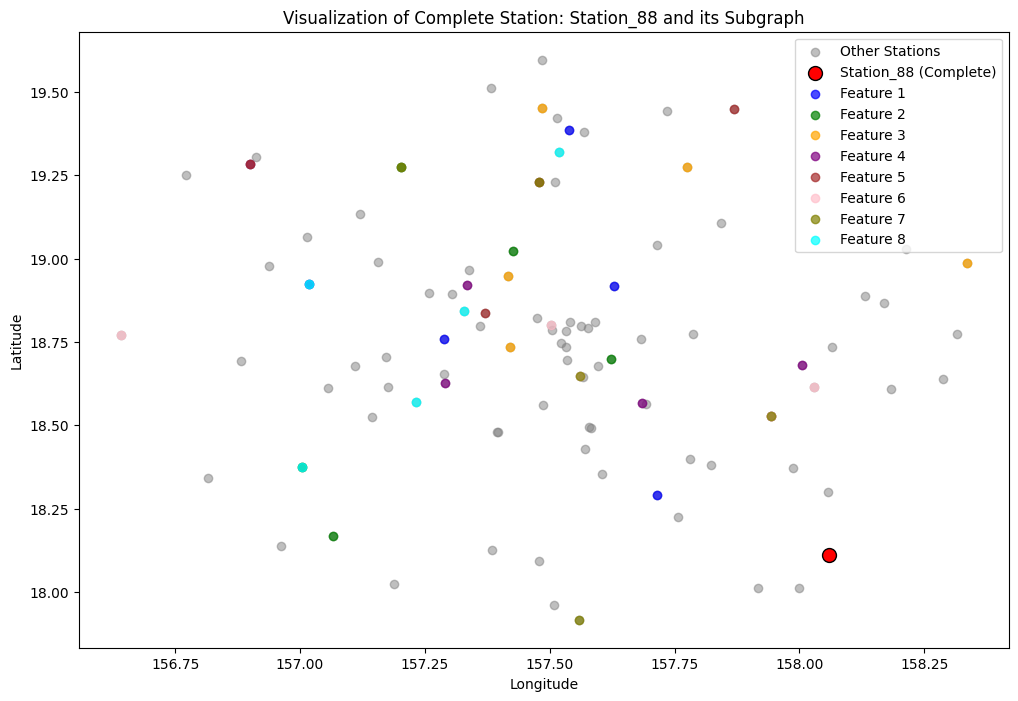

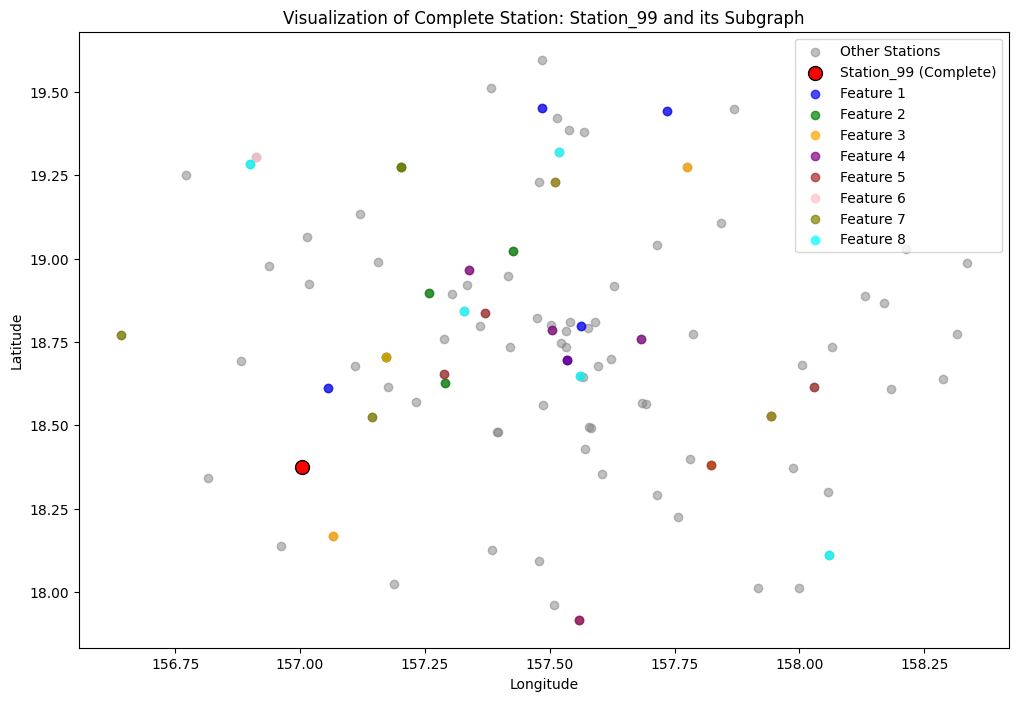

In [53]:
from scipy.stats import pearsonr
##########
# 2. Visualize_complete_stations_and_subgraph
##########
import matplotlib.pyplot as plt
from itertools import cycle
from matplotlib.patches import Polygon
# from MOESTKF_functions import distance,midpoint,subdivide_triangle,sample_points_in_triangle,correlation,calculate_correlations
# from MOESTKF_functions import get_complete_stations,Feature_wise_Subgraph,visualize_complete_stations_and_subgraph
# from MOESTKF_functions import is_point_inside_triangle, determine_points_in_triangles,calculate_average_properties_in_triangles,plot_triangle_centroids
from MOESTKF_functions import *

visualize_complete_stations_and_subgraph(station_info, subgraph_matrix, complete_stations, complete_indices)

Step 2). Distribution generation of spatial correlations for different feature.

In [54]:
###################################################
#Generate the adjacency matrix distribution.
###################################################
import time
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull
from shapely.geometry import Polygon, Point
import matplotlib.colors as mcolors

# from MOESTKF_functions import convex_hull,create_polygon_matrix,compute_adjacency_matrix_with_decay
from MOESTKF_functions import *

# Convert station_info to a dictionary for easy lookup
station_coords = {row[0]: (float(row[1]), float(row[2])) for row in station_info}

# Measure time to compute the adjacency matrices with decay
start_time = time.time()
adjacency_matrices_with_decay = compute_adjacency_matrix_with_decay(complete_sub_matrix, station_value, station_info)
end_time = time.time()
print(f"Time to compute adjacency matrices with decay: {end_time - start_time:.4f} seconds")

# Example to verify the adjacency matrices
print("Adjacency matrix with decay for the first king station and first feature:")
print(adjacency_matrices_with_decay[0][0])

# Print the shape of the adjacency matrices to verify
print(f"Shape of adjacency_matrices_with_decay: {len(adjacency_matrices_with_decay)} x {len(adjacency_matrices_with_decay[0])}")
print(f"Shape of each adjacency matrix: {adjacency_matrices_with_decay[0][0].shape}")




Time to compute adjacency matrices with decay: 0.0943 seconds
Adjacency matrix with decay for the first king station and first feature:
[[ 1.00000000e+00  2.03889737e-02  1.89985317e-02  1.73910797e-02
   1.42739464e-02  1.40984257e-02]
 [ 2.03889737e-02  1.00000000e+00  4.37234220e-03 -9.98279992e-04
   1.09149422e-02  1.25566379e-02]
 [ 1.89985317e-02  4.37234220e-03  1.00000000e+00 -5.36100450e-03
   4.17692345e-03 -1.41605793e-03]
 [ 1.73910797e-02 -9.98279992e-04 -5.36100450e-03  1.00000000e+00
  -5.38322679e-03  1.07137302e-02]
 [ 1.42739464e-02  1.09149422e-02  4.17692345e-03 -5.38322679e-03
   1.00000000e+00 -2.74796730e-04]
 [ 1.40984257e-02  1.25566379e-02 -1.41605793e-03  1.07137302e-02
  -2.74796730e-04  1.00000000e+00]]
Shape of adjacency_matrices_with_decay: 12 x 8
Shape of each adjacency matrix: (6, 6)


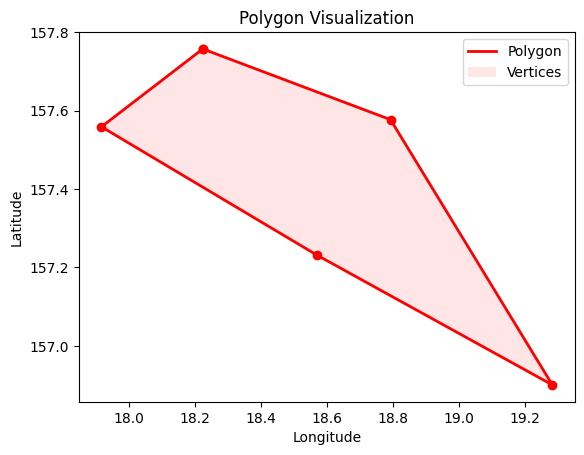

In [55]:
####################################################################
#Generate the correlated polygons under each king among each feature.
####################################################################
import random
from scipy.spatial import ConvexHull
import matplotlib.pyplot as plt
from shapely.geometry import Point, Polygon
import numpy as np

# Convert station_info to a dictionary for easy lookup
station_coords = {row[0]: (float(row[1]), float(row[2])) for row in station_info}

def convex_hull(points):
    if len(points) < 3:
        return points  # Convex hull is not defined for fewer than 3 points
    hull = ConvexHull(points)
    return [points[vertex] for vertex in hull.vertices]

def create_polygon_matrix(complete_sub_matrix, station_coords):
    complete_sub_polygon = np.empty((complete_sub_matrix.shape[0], complete_sub_matrix.shape[1]), dtype=object)
    for i in range(complete_sub_matrix.shape[0]):
        for j in range(complete_sub_matrix.shape[1]):
            stations = complete_sub_matrix[i, j]
            coords = [station_coords[station] for station in stations if station in station_coords]
            if len(coords) > 2:
                hull_coords = convex_hull(coords)
                complete_sub_polygon[i, j] = Polygon(hull_coords)
            else:
                complete_sub_polygon[i, j] = Polygon(coords)
    return complete_sub_polygon

# Generate the Complete_Sub_polygon matrix
Complete_Sub_polygon = create_polygon_matrix(complete_sub_matrix, station_coords)

# Example usage: plot the first polygon in the matrix
polygon = Complete_Sub_polygon[0, 0]

def plot_polygon(polygon):
    fig, ax = plt.subplots()
    if polygon.is_valid:
        x, y = polygon.exterior.xy
        ax.plot(x, y, 'r-', lw=2)
        ax.fill(x, y, 'red', alpha=0.1)
        ax.scatter(x, y, color='red')
    
    ax.set_title('Polygon Visualization')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.legend(['Polygon', 'Vertices'])
    plt.show()

# Plot the first polygon
plot_polygon(polygon)

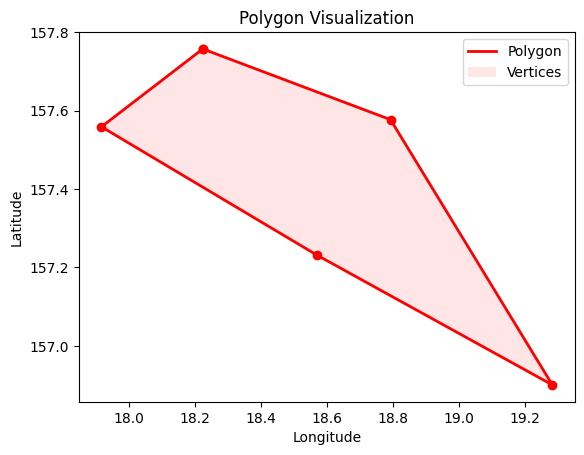

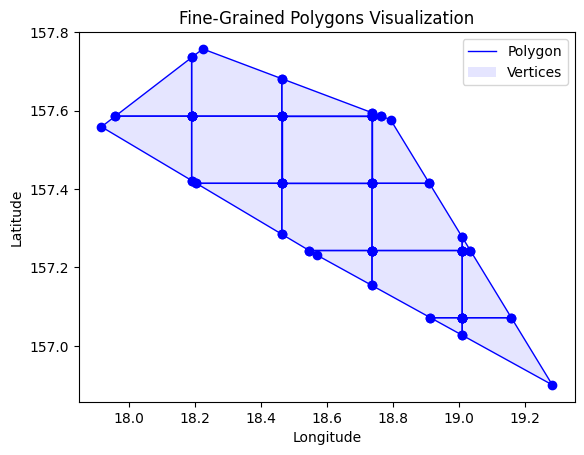

In [56]:
import random
from scipy.spatial import ConvexHull
import matplotlib.pyplot as plt
from shapely.geometry import Point, Polygon
import numpy as np
from shapely.ops import unary_union

# Convert station_info to a dictionary for easy lookup
station_coords = {row[0]: (float(row[1]), float(row[2])) for row in station_info}

def convex_hull(points):
    if len(points) < 3:
        return points  # Convex hull is not defined for fewer than 3 points
    hull = ConvexHull(points)
    return [points[vertex] for vertex in hull.vertices]

def create_polygon_matrix(complete_sub_matrix, station_coords):
    complete_sub_polygon = np.empty((complete_sub_matrix.shape[0], complete_sub_matrix.shape[1]), dtype=object)
    for i in range(complete_sub_matrix.shape[0]):
        for j in range(complete_sub_matrix.shape[1]):
            stations = complete_sub_matrix[i, j]
            coords = [station_coords[station] for station in stations if station in station_coords]
            if len(coords) > 2:
                hull_coords = convex_hull(coords)
                complete_sub_polygon[i, j] = Polygon(hull_coords)
            else:
                complete_sub_polygon[i, j] = Polygon(coords)
    return complete_sub_polygon

# Generate the Complete_Sub_polygon matrix
Complete_Sub_polygon = create_polygon_matrix(complete_sub_matrix, station_coords)

# Example usage: plot the first polygon in the matrix
polygon = Complete_Sub_polygon[0, 0]

def plot_polygon(polygon):
    fig, ax = plt.subplots()
    if polygon.is_valid:
        x, y = polygon.exterior.xy
        ax.plot(x, y, 'r-', lw=2)
        ax.fill(x, y, 'red', alpha=0.1)
        ax.scatter(x, y, color='red')
    
    ax.set_title('Polygon Visualization')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.legend(['Polygon', 'Vertices'])
    plt.show()

# Plot the first polygon
plot_polygon(polygon)

def subdivide_polygon(polygon, num_subdivisions):
    minx, miny, maxx, maxy = polygon.bounds
    width = (maxx - minx) / num_subdivisions
    height = (maxy - miny) / num_subdivisions
    sub_polygons = []
    for i in range(num_subdivisions):
        for j in range(num_subdivisions):
            sub_poly = Polygon([
                (minx + i * width, miny + j * height),
                (minx + (i + 1) * width, miny + j * height),
                (minx + (i + 1) * width, miny + (j + 1) * height),
                (minx + i * width, miny + (j + 1) * height)
            ])
            if sub_poly.intersects(polygon):
                sub_polygons.append(sub_poly.intersection(polygon))
    return sub_polygons

def create_fine_grained_polygons(Complete_Sub_polygon, num_subdivisions):
    fine_grained_polygons = np.empty_like(Complete_Sub_polygon, dtype=object)
    for i in range(Complete_Sub_polygon.shape[0]):
        for j in range(Complete_Sub_polygon.shape[1]):
            coarse_polygon = Complete_Sub_polygon[i, j]
            if coarse_polygon.is_valid:
                fine_polygons = subdivide_polygon(coarse_polygon, num_subdivisions)
                fine_grained_polygons[i, j] = fine_polygons
    return fine_grained_polygons

# Generate the fine-grained polygons
num_subdivisions = 5  # Adjust this as needed for finer or coarser subdivisions
fine_grained_polygons = create_fine_grained_polygons(Complete_Sub_polygon, num_subdivisions)


# Example usage: plot the fine-grained polygons and display adjacency matrix for the first coarse polygon
fine_polygons = fine_grained_polygons[0, 0]

def plot_fine_polygons(fine_polygons):
    fig, ax = plt.subplots()
    for poly in fine_polygons:
        if poly.is_valid:
            x, y = poly.exterior.xy
            ax.plot(x, y, 'b-', lw=1)
            ax.fill(x, y, 'blue', alpha=0.1)
            ax.scatter(x, y, color='blue')
    
    ax.set_title('Fine-Grained Polygons Visualization')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.legend(['Polygon', 'Vertices'])
    plt.show()

# Plot the fine-grained polygons
plot_fine_polygons(fine_polygons)


/tmp/ipykernel_1724210/1089464317.py:16: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  complete_sub_matrix = np.array([


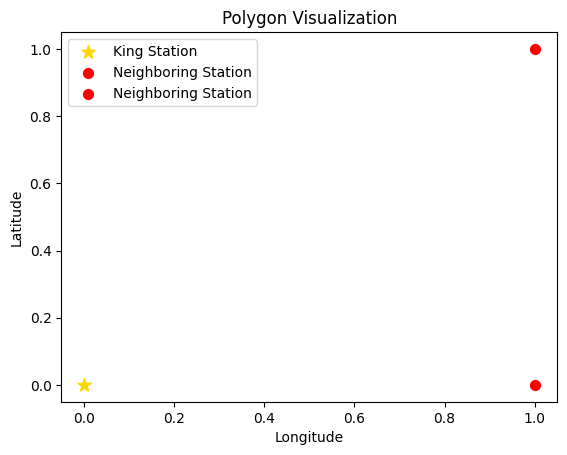

TypeError: object of type 'NoneType' has no len()

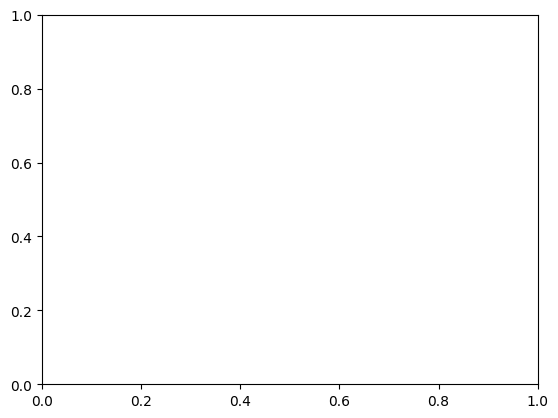

In [48]:
import random
from scipy.spatial import ConvexHull
import matplotlib.pyplot as plt
from shapely.geometry import Point, Polygon
import numpy as np

# Example data for station_info and complete_sub_matrix
station_info = [
    ('Station_1', '0', '0'),
    ('Station_2', '1', '0'),
    ('Station_3', '1', '1'),
    ('Station_4', '0', '1'),
    ('Station_5', '0.5', '0.5')
]

complete_sub_matrix = np.array([
    [['Station_1', 'Station_2', 'Station_3'], ['Station_4', 'Station_5']],
    [['Station_1', 'Station_4', 'Station_5'], ['Station_2', 'Station_3']]
])

# Convert station_info to a dictionary for easy lookup
station_coords = {row[0]: (float(row[1]), float(row[2])) for row in station_info}

def convex_hull(points):
    if len(points) < 3:
        return []
    hull = ConvexHull(points)
    return hull.vertices

def create_polygon_matrix(complete_sub_matrix, station_coords):
    complete_sub_polygon = np.empty((complete_sub_matrix.shape[0], complete_sub_matrix.shape[1]), dtype=object)
    for i in range(complete_sub_matrix.shape[0]):
        for j in range(complete_sub_matrix.shape[1]):
            stations = complete_sub_matrix[i, j]
            coords = [station_coords[station] for station in stations if station in station_coords]
            if len(coords) >= 3:
                hull_indices = convex_hull(coords)
                hull_coords = [coords[k] for k in hull_indices]
                if len(hull_coords) >= 4:
                    complete_sub_polygon[i, j] = Polygon(hull_coords)
                else:
                    complete_sub_polygon[i, j] = Polygon()
            else:
                complete_sub_polygon[i, j] = Polygon()
    return complete_sub_polygon

# Generate the Complete_Sub_polygon matrix
Complete_Sub_polygon = create_polygon_matrix(complete_sub_matrix, station_coords)

# Example usage: plot the first polygon in the matrix
polygon = Complete_Sub_polygon[0, 0]

def plot_polygon(polygon, king_station, neighboring_stations):
    fig, ax = plt.subplots()
    if polygon.is_valid and not polygon.is_empty:
        x, y = polygon.exterior.xy
        ax.plot(x, y, 'r-', lw=2)
        ax.fill(x, y, 'red', alpha=0.1)
    
    # Plot king station
    king_x, king_y = king_station
    ax.scatter(king_x, king_y, color='gold', marker='*', s=100, label='King Station')
    
    # Plot neighboring stations
    for station in neighboring_stations:
        neigh_x, neigh_y = station
        ax.scatter(neigh_x, neigh_y, color='red', marker='o', s=50, label='Neighboring Station')
    
    ax.set_title('Polygon Visualization')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.legend()
    plt.show()

# Define king station and neighboring stations for the plot
king_station = station_coords['Station_1']
neighboring_stations = [station_coords[station] for station in ['Station_2', 'Station_3']]

# Plot the first polygon with king station and neighboring stations
plot_polygon(polygon, king_station, neighboring_stations)

def subdivide_polygon(polygon, num_subdivisions):
    minx, miny, maxx, maxy = polygon.bounds
    width = (maxx - minx) / num_subdivisions
    height = (maxy - miny) / num_subdivisions
    sub_polygons = []
    for i in range(num_subdivisions):
        for j in range(num_subdivisions):
            sub_poly = Polygon([
                (minx + i * width, miny + j * height),
                (minx + (i + 1) * width, miny + j * height),
                (minx + (i + 1) * width, miny + (j + 1) * height),
                (minx + i * width, miny + (j + 1) * height)
            ])
            if sub_poly.intersects(polygon):
                sub_polygons.append(sub_poly.intersection(polygon))
    return sub_polygons

def create_fine_grained_polygons(Complete_Sub_polygon, num_subdivisions):
    fine_grained_polygons = np.empty_like(Complete_Sub_polygon, dtype=object)
    for i in range(Complete_Sub_polygon.shape[0]):
        for j in range(Complete_Sub_polygon.shape[1]):
            coarse_polygon = Complete_Sub_polygon[i, j]
            if coarse_polygon.is_valid and not coarse_polygon.is_empty:
                fine_polygons = subdivide_polygon(coarse_polygon, num_subdivisions)
                fine_grained_polygons[i, j] = fine_polygons
    return fine_grained_polygons

# Generate the fine-grained polygons
num_subdivisions = 5  # Adjust this as needed for finer or coarser subdivisions
fine_grained_polygons = create_fine_grained_polygons(Complete_Sub_polygon, num_subdivisions)

# Example usage: plot the fine-grained polygons and display adjacency matrix for the first coarse polygon
fine_polygons = fine_grained_polygons[0, 0]

def plot_fine_polygons(fine_polygons, king_station):
    fig, ax = plt.subplots()
    colors = plt.cm.viridis(np.linspace(0, 1, len(fine_polygons)))
    for poly, color in zip(fine_polygons, colors):
        if poly.is_valid:
            x, y = poly.exterior.xy
            ax.plot(x, y, color=color, lw=1)
            ax.fill(x, y, color=color, alpha=0.5)
            ax.scatter(x, y, color=color)
    
    # Plot king station
    king_x, king_y = king_station
    ax.scatter(king_x, king_y, color='gold', marker='*', s=100, label='King Station')
    
    ax.set_title('Fine-Grained Polygons Visualization')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.legend()
    plt.show()

# Plot the fine-grained polygons with king station
plot_fine_polygons(fine_polygons, king_station)


In [24]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial import ConvexHull
from shapely.geometry import Point, Polygon

# Example data for station_info and complete_sub_matrix
station_info = [
    ('Station_1', '0', '0'),
    ('Station_2', '1', '0'),
    ('Station_3', '1', '1'),
    ('Station_4', '0', '1'),
    ('Station_5', '0.5', '0.5')
]

complete_sub_matrix = np.array([
    [['Station_1', 'Station_2', 'Station_3'], ['Station_4', 'Station_5']],
    [['Station_1', 'Station_4', 'Station_5'], ['Station_2', 'Station_3']]
])

# Convert station_info to a dictionary for easy lookup
station_coords = {row[0]: (float(row[1]), float(row[2])) for row in station_info}

def convex_hull(points):
    if len(points) < 3:
        return points  # Convex hull is not defined for fewer than 3 points
    hull = ConvexHull(points)
    return [points[vertex] for vertex in hull.vertices]

def create_polygon_matrix(complete_sub_matrix, station_coords):
    complete_sub_polygon = np.empty((complete_sub_matrix.shape[0], complete_sub_matrix.shape[1]), dtype=object)
    for i in range(complete_sub_matrix.shape[0]):
        for j in range(complete_sub_matrix.shape[1]):
            stations = complete_sub_matrix[i, j]
            coords = [station_coords[station] for station in stations if station in station_coords]
            if len(coords) >= 3:
                hull_coords = [coords[k] for k in convex_hull(coords)]
                if len(hull_coords) >= 4:
                    complete_sub_polygon[i, j] = Polygon(hull_coords)
                else:
                    complete_sub_polygon[i, j] = Polygon()
            else:
                complete_sub_polygon[i, j] = Polygon()
    return complete_sub_polygon

# Generate the Complete_Sub_polygon matrix
Complete_Sub_polygon = create_polygon_matrix(complete_sub_matrix, station_coords)

# Example usage: plot the first polygon in the matrix
polygon = Complete_Sub_polygon[0, 0]

def plot_polygon(polygon, king_station, neighboring_stations):
    fig, ax = plt.subplots()
    if polygon.is_valid and not polygon.is_empty:
        x, y = polygon.exterior.xy
        ax.plot(x, y, 'r-', lw=2)
        ax.fill(x, y, 'red', alpha=0.1)
    
    # Plot king station
    king_x, king_y = king_station
    ax.scatter(king_x, king_y, color='red', marker='o', s=100, label='King Station')
    
    # Plot neighboring stations
    for station in neighboring_stations:
        neigh_x, neigh_y = station
        ax.scatter(neigh_x, neigh_y, color='red', marker='o', s=50, label='Neighboring Station')
    
    ax.set_title('Polygon Visualization')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.legend()
    plt.show()

# Example king station and neighboring stations
king_station = station_coords['Station_1']
neighboring_stations = [station_coords['Station_2'], station_coords['Station_3']]

# Plot the first polygon with king station and neighboring stations
plot_polygon(polygon, king_station, neighboring_stations)

def subdivide_polygon(polygon, num_subdivisions):
    minx, miny, maxx, maxy = polygon.bounds
    width = (maxx - minx) / num_subdivisions
    height = (maxy - miny) / num_subdivisions
    sub_polygons = []
    for i in range(num_subdivisions):
        for j in range(num_subdivisions):
            sub_poly = Polygon([
                (minx + i * width, miny + j * height),
                (minx + (i + 1) * width, miny + j * height),
                (minx + (i + 1) * width, miny + (j + 1) * height),
                (minx + i * width, miny + (j + 1) * height)
            ])
            if sub_poly.intersects(polygon):
                sub_polygons.append(sub_poly.intersection(polygon))
    return sub_polygons

def create_fine_grained_polygons(Complete_Sub_polygon, num_subdivisions):
    fine_grained_polygons = np.empty_like(Complete_Sub_polygon, dtype=object)
    for i in range(Complete_Sub_polygon.shape[0]):
        for j in range(Complete_Sub_polygon.shape[1]):
            coarse_polygon = Complete_Sub_polygon[i, j]
            if coarse_polygon.is_valid and not coarse_polygon.is_empty:
                fine_polygons = subdivide_polygon(coarse_polygon, num_subdivisions)
                fine_grained_polygons[i, j] = fine_polygons
    return fine_grained_polygons

# Generate the fine-grained polygons
num_subdivisions = 5  # Adjust this as needed for finer or coarser subdivisions
fine_grained_polygons = create_fine_grained_polygons(Complete_Sub_polygon, num_subdivisions)

# Example usage: plot the fine-grained polygons and display adjacency matrix for the first coarse polygon
fine_polygons = fine_grained_polygons[0, 0]

def inverse_distance_color(poly, king_station, neighboring_stations):
    center = poly.centroid
    distance_to_king = center.distance(Point(king_station))
    distance_to_neighbors = [center.distance(Point(station)) for station in neighboring_stations]
    min_distance = min([distance_to_king] + distance_to_neighbors)
    max_distance = max([distance_to_king] + distance_to_neighbors)
    normalized_distance = (min_distance - max_distance) / (max_distance - min_distance) if max_distance != min_distance else 0
    return plt.cm.viridis(normalized_distance)

def plot_fine_polygons(fine_polygons, king_station, neighboring_stations):
    fig, ax = plt.subplots()
    for poly in fine_polygons:
        if poly.is_valid and not poly.is_empty:
            color = inverse_distance_color(poly, king_station, neighboring_stations)
            x, y = poly.exterior.xy
            ax.plot(x, y, color=color, lw=1)
            ax.fill(x, y, color=color, alpha=0.5)
    
    # Plot king station
    king_x, king_y = king_station
    ax.scatter(king_x, king_y, color='gold', marker='*', s=100, label='King Station')
    
    ax.set_title('Fine-Grained Polygons Visualization')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.legend()
    plt.show()

# Plot the fine-grained polygons with king station and neighboring stations
plot_fine_polygons(fine_polygons, king_station, neighboring_stations)


/tmp/ipykernel_1724210/3040793873.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  complete_sub_matrix = np.array([


TypeError: list indices must be integers or slices, not tuple

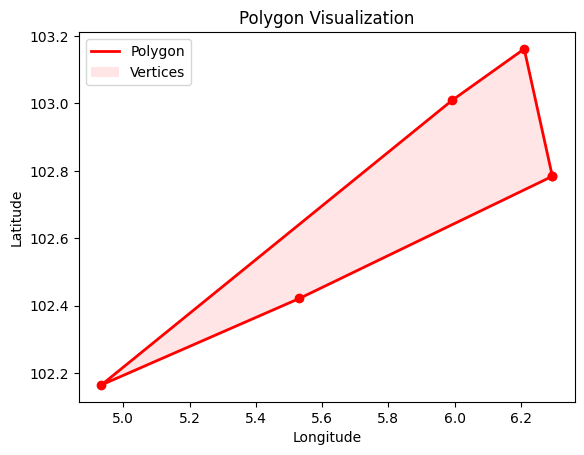

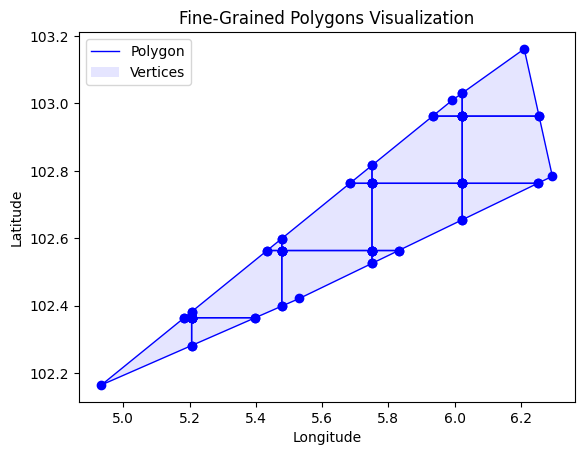

Adj matrix for the first fine-grained polygon:
[[1.         0.5396499  0.40151499 0.30566625 0.47089252 0.39865975]
 [0.5396499  1.         0.26682259 0.43822438 0.51337326 0.46945582]
 [0.40151499 0.26682259 1.         0.1268442  0.56579188 0.81142925]
 [0.30566625 0.43822438 0.1268442  1.         0.57380062 0.41555873]
 [0.47089252 0.51337326 0.56579188 0.57380062 1.         0.82702233]
 [0.39865975 0.46945582 0.81142925 0.41555873 0.82702233 1.        ]]


In [9]:
import random
from scipy.spatial import ConvexHull
import matplotlib.pyplot as plt
from shapely.geometry import Point, Polygon
import numpy as np
from shapely.ops import unary_union
from MOESTKF_functions import *
# Convert station_info to a dictionary for easy lookup
station_coords = {row[0]: (float(row[1]), float(row[2])) for row in station_info}

def convex_hull(points):
    if len(points) < 3:
        return points  # Convex hull is not defined for fewer than 3 points
    hull = ConvexHull(points)
    return [points[vertex] for vertex in hull.vertices]

def create_polygon_matrix(complete_sub_matrix, station_coords):
    complete_sub_polygon = np.empty((complete_sub_matrix.shape[0], complete_sub_matrix.shape[1]), dtype=object)
    for i in range(complete_sub_matrix.shape[0]):
        for j in range(complete_sub_matrix.shape[1]):
            stations = complete_sub_matrix[i, j]
            coords = [station_coords[station] for station in stations if station in station_coords]
            if len(coords) > 2:
                hull_coords = convex_hull(coords)
                complete_sub_polygon[i, j] = Polygon(hull_coords)
            else:
                complete_sub_polygon[i, j] = Polygon(coords)
    return complete_sub_polygon

# Generate the Complete_Sub_polygon matrix
Complete_Sub_polygon = create_polygon_matrix(complete_sub_matrix, station_coords)

# Example usage: plot the first polygon in the matrix
polygon = Complete_Sub_polygon[0, 0]

def plot_polygon(polygon):
    fig, ax = plt.subplots()
    if polygon.is_valid:
        x, y = polygon.exterior.xy
        ax.plot(x, y, 'r-', lw=2)
        ax.fill(x, y, 'red', alpha=0.1)
        ax.scatter(x, y, color='red')
    
    ax.set_title('Polygon Visualization')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.legend(['Polygon', 'Vertices'])
    plt.show()

# Plot the first polygon
plot_polygon(polygon)

def subdivide_polygon(polygon, num_subdivisions):
    minx, miny, maxx, maxy = polygon.bounds
    width = (maxx - minx) / num_subdivisions
    height = (maxy - miny) / num_subdivisions
    sub_polygons = []
    for i in range(num_subdivisions):
        for j in range(num_subdivisions):
            sub_poly = Polygon([
                (minx + i * width, miny + j * height),
                (minx + (i + 1) * width, miny + j * height),
                (minx + (i + 1) * width, miny + (j + 1) * height),
                (minx + i * width, miny + (j + 1) * height)
            ])
            if sub_poly.intersects(polygon):
                sub_polygons.append(sub_poly.intersection(polygon))
    return sub_polygons

def create_fine_grained_polygons(Complete_Sub_polygon, num_subdivisions):
    fine_grained_polygons = np.empty_like(Complete_Sub_polygon, dtype=object)
    for i in range(Complete_Sub_polygon.shape[0]):
        for j in range(Complete_Sub_polygon.shape[1]):
            coarse_polygon = Complete_Sub_polygon[i, j]
            if coarse_polygon.is_valid:
                fine_polygons = subdivide_polygon(coarse_polygon, num_subdivisions)
                fine_grained_polygons[i, j] = fine_polygons
    return fine_grained_polygons

# Generate the fine-grained polygons
num_subdivisions = 5  # Adjust this as needed for finer or coarser subdivisions
fine_grained_polygons = create_fine_grained_polygons(Complete_Sub_polygon, num_subdivisions)
fine_polygons = fine_grained_polygons[0, 0]

def plot_fine_polygons(fine_polygons):
    fig, ax = plt.subplots()
    for poly in fine_polygons:
        if poly.is_valid:
            x, y = poly.exterior.xy
            ax.plot(x, y, 'b-', lw=1)
            ax.fill(x, y, 'blue', alpha=0.1)
            ax.scatter(x, y, color='blue')
    
    ax.set_title('Fine-Grained Polygons Visualization')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.legend(['Polygon', 'Vertices'])
    plt.show()

# Plot the fine-grained polygons
plot_fine_polygons(fine_polygons)


def generate_adj_matrix_for_polygons(fine_grained_polygons):
    polygon_matrices = np.empty_like(fine_grained_polygons, dtype=object)
    for i in range(fine_grained_polygons.shape[0]):
        for j in range(fine_grained_polygons.shape[1]):
            fine_polygons = fine_grained_polygons[i, j]
            if fine_polygons:
                matrices = []
                for _ in fine_polygons:
                    matrix = np.random.rand(6, 6)
                    np.fill_diagonal(matrix, 1)
                    matrix = (matrix + matrix.T) / 2  # Make the matrix symmetric
                    matrices.append(matrix)
                polygon_matrices[i, j] = matrices
    return polygon_matrices


# Generate the random matrices
polygon_matrices = generate_adj_matrix_for_polygons(fine_grained_polygons)

# Example: print the random matrix of the first fine-grained polygon
print("Adj matrix for the first fine-grained polygon:")
print(polygon_matrices[0, 0][0])


In [16]:
polygon_matrices[0,0][0][0,0]

1.0

In [10]:
len(polygon_matrices[0, 0])

15

In [ ]:
complete_sub_matrix, station_info

In [ ]:
station_value

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data

class GNNTimeSeriesPyG(nn.Module):
    def __init__(self, num_nodes, num_timesteps, hidden_dim):
        super(GNNTimeSeriesPyG, self).__init__()
        self.num_nodes = num_nodes
        self.num_timesteps = num_timesteps
        self.hidden_dim = hidden_dim
        
        # Learnable adjacency matrix
        self.adj_matrix = nn.Parameter(torch.rand(num_nodes, num_nodes))
        
        # Graph convolutional layer
        self.gcn = GCNConv(num_timesteps, hidden_dim)
        
        # Output layer for prediction
        self.output_layer = nn.Linear(hidden_dim, 1)
    
    def forward(self, data):
        A = F.softmax(self.adj_matrix, dim=1)  # Normalize adjacency matrix
        x, edge_index = data.x, data.edge_index
        x = torch.matmul(A, x)  # Apply adjacency matrix
        x = self.gcn(x, edge_index)
        x = F.relu(x)
        x = self.output_layer(x)
        return x

# Parameters
num_nodes = 4
num_timesteps = 500
hidden_dim = 128

# Create a sample graph
edge_index = torch.tensor([[i, j] for i in range(num_nodes) for j in range(num_nodes)], dtype=torch.long).t().contiguous()
data = torch.randn(num_nodes, num_timesteps)  # Example feature matrix with 4 nodes and 500 timesteps
targets = torch.randn(num_nodes, 1)  # Example target values

# Create a PyTorch Geometric graph
graph_data = Data(x=data, edge_index=edge_index)

# Model instantiation
model = GNNTimeSeriesPyG(num_nodes, num_timesteps, hidden_dim)

# Training parameters
learning_rate = 0.01
num_epochs = 1000

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    
    # Forward pass
    predictions = model(graph_data)
    
    # Compute loss
    loss = criterion(predictions, targets)
    
    # Backward pass and optimization
    loss.backward()
    optimizer.step()
    
    if epoch % 100 == 0:
        print(f'Epoch [{epoch}/{num_epochs}], Loss: {loss.item():.4f}')

# Best adjacency matrix
best_adj_matrix = model.adj_matrix.detach().numpy()
print("Best Adjacency Matrix:")
print(best_adj_matrix)

Epoch [0/1000], Loss: 0.2410
Epoch [100/1000], Loss: 0.2170
Epoch [200/1000], Loss: 0.2170
Epoch [300/1000], Loss: 0.2170
Epoch [400/1000], Loss: 0.2170
Epoch [500/1000], Loss: 0.2170
Epoch [600/1000], Loss: 0.2170
Epoch [700/1000], Loss: 0.2170
Epoch [800/1000], Loss: 0.2170
Epoch [900/1000], Loss: 0.2170
Best Adjacency Matrix:
[[0.7383611  0.60092354 0.16684005 0.21169667]
 [0.83960664 0.13692254 0.83931607 0.23800826]
 [0.5436758  0.6299311  0.05563984 0.16861431]
 [0.5003102  0.46189466 0.744344   0.66194075]]


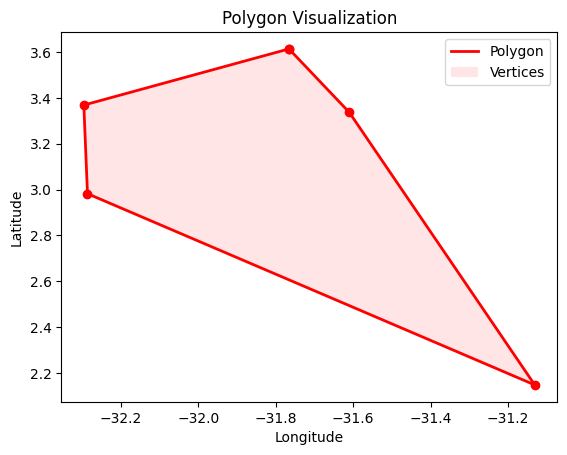

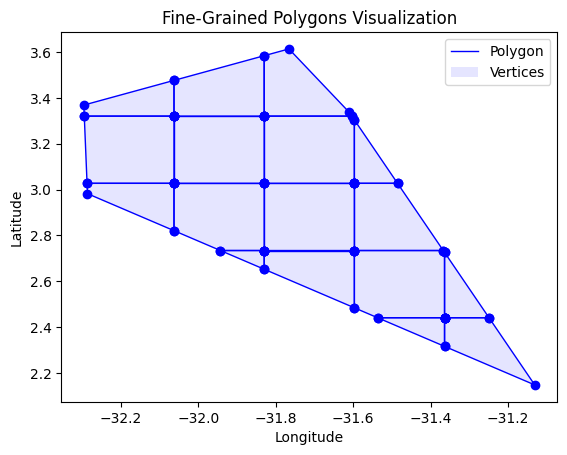

station_indices ['0', '74', '56', '85', '42', '93']
coords [(-32.15079433262624, 2.9555672541213918), (-32.17691550822692, 3.1745540581774394), (-32.15863229993439, 3.376297167986552), (-31.867481920257852, 2.7065522375820783), (-31.93999469879997, 2.890140017350024), (-31.94629001617432, 3.173786807060242), (-31.936320554792268, 3.427697091516702), (-31.69358773881478, 2.643737014215356), (-31.71329402923584, 2.880449891090393), (-31.713383602507545, 3.173676135277419), (-31.74750533393506, 3.4359346825622565), (-31.421477662094254, 2.398775127964507), (-31.47845114035659, 2.5896462330951953), (-31.50806633461602, 2.8635263940630726), (-31.55960473364529, 3.1194633748951444), (-31.265600751992608, 2.323345006614332), (-31.325514505127853, 2.535506516040508)]
Skipping due to mismatch in length: coords(17) vs station_indices(6)
station_indices ['0', '45', '10', '6', '15', '9']
coords [(-32.03493665059407, 3.1415111107478704), (-32.108124400039706, 3.280645638460852), (-31.71289532979329

ZeroDivisionError: float division by zero

In [11]:
import random
from scipy.spatial import ConvexHull
import matplotlib.pyplot as plt
from shapely.geometry import Point, Polygon
import numpy as np
from shapely.ops import unary_union
from scipy.stats import pearsonr
from scipy.spatial.distance import euclidean

# 示例数据，实际使用时需替换
# station_info = ...
# station_value = ...
# complete_sub_matrix = ...

# Convert station_info to a dictionary for easy lookup
station_coords = {row[0]: (float(row[1]), float(row[2])) for row in station_info}

def convex_hull(points):
    if len(points) < 3:
        return points  # Convex hull is not defined for fewer than 3 points
    hull = ConvexHull(points)
    return [points[vertex] for vertex in hull.vertices]

def create_polygon_matrix(complete_sub_matrix, station_coords):
    complete_sub_polygon = np.empty((complete_sub_matrix.shape[0], complete_sub_matrix.shape[1]), dtype=object)
    for i in range(complete_sub_matrix.shape[0]):
        for j in range(complete_sub_matrix.shape[1]):
            stations = complete_sub_matrix[i, j]
            coords = [station_coords[station] for station in stations if station in station_coords]
            if len(coords) > 2:
                hull_coords = convex_hull(coords)
                complete_sub_polygon[i, j] = Polygon(hull_coords)
            else:
                complete_sub_polygon[i, j] = Polygon(coords)
    return complete_sub_polygon

# Generate the Complete_Sub_polygon matrix
Complete_Sub_polygon = create_polygon_matrix(complete_sub_matrix, station_coords)

# Example usage: plot the first polygon in the matrix
polygon = Complete_Sub_polygon[0, 0]

def plot_polygon(polygon):
    fig, ax = plt.subplots()
    if polygon.is_valid:
        x, y = polygon.exterior.xy
        ax.plot(x, y, 'r-', lw=2)
        ax.fill(x, y, 'red', alpha=0.1)
        ax.scatter(x, y, color='red')
    
    ax.set_title('Polygon Visualization')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.legend(['Polygon', 'Vertices'])
    plt.show()

# Plot the first polygon
plot_polygon(polygon)

def subdivide_polygon(polygon, num_subdivisions):
    minx, miny, maxx, maxy = polygon.bounds
    width = (maxx - minx) / num_subdivisions
    height = (maxy - miny) / num_subdivisions
    sub_polygons = []
    for i in range(num_subdivisions):
        for j in range(num_subdivisions):
            sub_poly = Polygon([
                (minx + i * width, miny + j * height),
                (minx + (i + 1) * width, miny + j * height),
                (minx + (i + 1) * width, miny + (j + 1) * height),
                (minx + i * width, miny + (j + 1) * height)
            ])
            if sub_poly.intersects(polygon):
                sub_polygons.append(sub_poly.intersection(polygon))
    return sub_polygons

def create_fine_grained_polygons(Complete_Sub_polygon, num_subdivisions):
    fine_grained_polygons = np.empty_like(Complete_Sub_polygon, dtype=object)
    for i in range(Complete_Sub_polygon.shape[0]):
        for j in range(Complete_Sub_polygon.shape[1]):
            coarse_polygon = Complete_Sub_polygon[i, j]
            if coarse_polygon.is_valid:
                fine_polygons = subdivide_polygon(coarse_polygon, num_subdivisions)
                fine_grained_polygons[i, j] = fine_polygons
    return fine_grained_polygons

# Generate the fine-grained polygons
num_subdivisions = 5  # Adjust this as needed for finer or coarser subdivisions
fine_grained_polygons = create_fine_grained_polygons(Complete_Sub_polygon, num_subdivisions)
fine_polygons = fine_grained_polygons[0, 0]

def plot_fine_polygons(fine_polygons):
    fig, ax = plt.subplots()
    for poly in fine_polygons:
        if poly.is_valid:
            x, y = poly.exterior.xy
            ax.plot(x, y, 'b-', lw=1)
            ax.fill(x, y, 'blue', alpha=0.1)
            ax.scatter(x, y, color='blue')
    
    ax.set_title('Fine-Grained Polygons Visualization')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.legend(['Polygon', 'Vertices'])
    plt.show()

# Plot the fine-grained polygons
plot_fine_polygons(fine_polygons)

def get_centroid(polygon):
    centroid = polygon.centroid
    return (centroid.x, centroid.y)

def compute_weighted_correlation(station_value, coords, target_coords, den_fac, feature_index):
    correlations = []
    for coord in coords:
        distance = euclidean(coord, target_coords)
        weight = np.exp(-distance) ** den_fac
        correlation, _ = pearsonr(station_value, station_value)  # Using station_value correctly
        weighted_corr = correlation * weight
        correlations.append(weighted_corr)
    return correlations

station_indices_lookup = {str(station[0]).replace('Station_', ''): idx for idx, station in enumerate(station_info)}

def create_adjacency_matrix_for_polygon(fine_grained_polygons, complete_sub_matrix, station_info, station_value):
    fine_grained_polygon_adj = np.empty_like(fine_grained_polygons, dtype=object)
    
    # Create a lookup for station indices
    station_indices_lookup = {str(station[0]).replace('Station_', ''): idx for idx, station in enumerate(station_info)}
    
    for i in range(fine_grained_polygons.shape[0]):
        for j in range(fine_grained_polygons.shape[1]):
            fine_polygons = fine_grained_polygons[i, j]
            if not fine_polygons:
                continue  # Skip if no fine polygons
            
            king_station = complete_sub_matrix[i, j][0]
            target_station = complete_sub_matrix[i, j][-1]
            station_indices = [station.replace('Station_', '') for station in complete_sub_matrix[i, j]]  # 处理字符串编号
            print("station_indices",station_indices)
            if max(map(int, station_indices)) >= len(station_info):
                print(f"Skipping invalid station index in sub-matrix: {station_indices}")
                continue
            
            n = len(fine_polygons) - 1
            A = fine_polygons[0].area if n > 0 else 1  # Avoid division by zero
            den_fac = 1 / (2 * (n / A) ** 0.5)
            
            coords = [get_centroid(p) for p in fine_polygons]
            print("coords", coords)
            adjacency_matrix = np.zeros((len(coords) + 1, len(coords) + 1))  # Include space for target station

            if len(coords) != len(station_indices):
                print(f"Skipping due to mismatch in length: coords({len(coords)}) vs station_indices({len(station_indices)})")
                continue
            
            for m in range(len(coords)):
                for n in range(m + 1, len(coords)):
                    # Convert station names to indices
                    index_m = station_indices_lookup.get(station_indices[m])
                    print("index_m", index_m)
                    index_n = station_indices_lookup.get(station_indices[n])
                    print("index_n", index_n)
                    if index_m is None or index_n is None:
                        print(f"Skipping invalid index: {station_indices[m]} or {station_indices[n]}")
                        continue
                    
                    # Calculate Pearson correlation for each feature across all time steps
                    correlation, _ = pearsonr(station_value[index_m, :, j], station_value[index_n, :, j])
                    adjacency_matrix[m, n] = correlation
                    adjacency_matrix[n, m] = correlation
            
            # Calculate weighted correlations for the target station
            target_index = station_indices_lookup.get(str(target_station).replace('Station_', ''))
            if target_index is None:
                print(f"Skipping invalid target index: {target_station}")
                continue
            
            target_weighted_correlations = compute_weighted_correlation(station_value[target_index, :, j], coords, get_centroid(fine_polygons[-1]), den_fac, j)
            
            for m in range(len(coords)):
                adjacency_matrix[m, -1] = target_weighted_correlations[m]
                adjacency_matrix[-1, m] = target_weighted_correlations[m]
            
            fine_grained_polygon_adj[i, j] = adjacency_matrix
    
    return fine_grained_polygon_adj

# Generate the adjacency matrices for fine-grained polygons
polygon_matrices = create_adjacency_matrix_for_polygon(fine_grained_polygons, complete_sub_matrix, station_info, station_value)

# Example: print the adjacency matrix of the first fine-grained polygon
print("Adjacency matrix for the first fine-grained polygon:")
print(polygon_matrices[0, 0])


In [19]:
station_info

array([['Station_0', 6.012425899505615, 102.65103912353516],
       ['Station_1', 6.218395709991455, 103.00110626220703],
       ['Station_2', 5.6016693115234375, 102.57975769042969],
       ['Station_3', 5.348535537719727, 102.0721435546875],
       ['Station_4', 6.017487525939941, 103.13526153564453],
       ['Station_5', 5.116225242614746, 102.18610382080078],
       ['Station_6', 5.232369422912598, 103.07035064697266],
       ['Station_7', 6.314471244812012, 102.59280395507812],
       ['Station_8', 5.685988426208496, 102.67639923095703],
       ['Station_9', 5.660057544708252, 102.7170639038086],
       ['Station_10', 6.160157680511475, 102.38277435302734],
       ['Station_11', 5.562161922454834, 102.38954162597656],
       ['Station_12', 5.722423553466797, 102.65603637695312],
       ['Station_13', 5.730375289916992, 102.63887786865234],
       ['Station_14', 5.901367664337158, 102.30313873291016],
       ['Station_15', 5.655762195587158, 102.6720962524414],
       ['Station_16'

Step 3). Mask training strategy for target feature-based functions.

Step 4). Mask training strategy for auxiliary feature-based functions.